In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

#### Loading the dataset

In [29]:
data = pd.read_csv('hotel_bookings.csv')
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

#### EDA & preprocessing

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

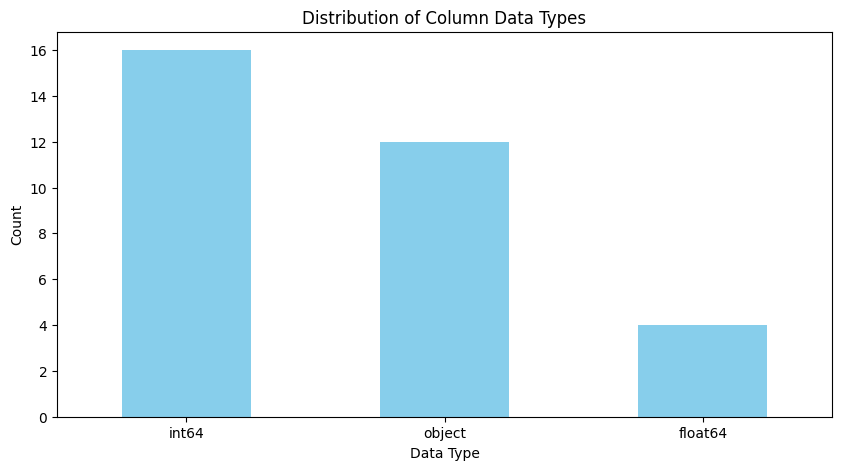

In [31]:
plt.figure(figsize=(10, 5))
data.dtypes.value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Column Data Types")
plt.xlabel("Data Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [32]:
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0]) 

Missing Values:
children         4
country        488
agent        16340
company     112593
dtype: int64


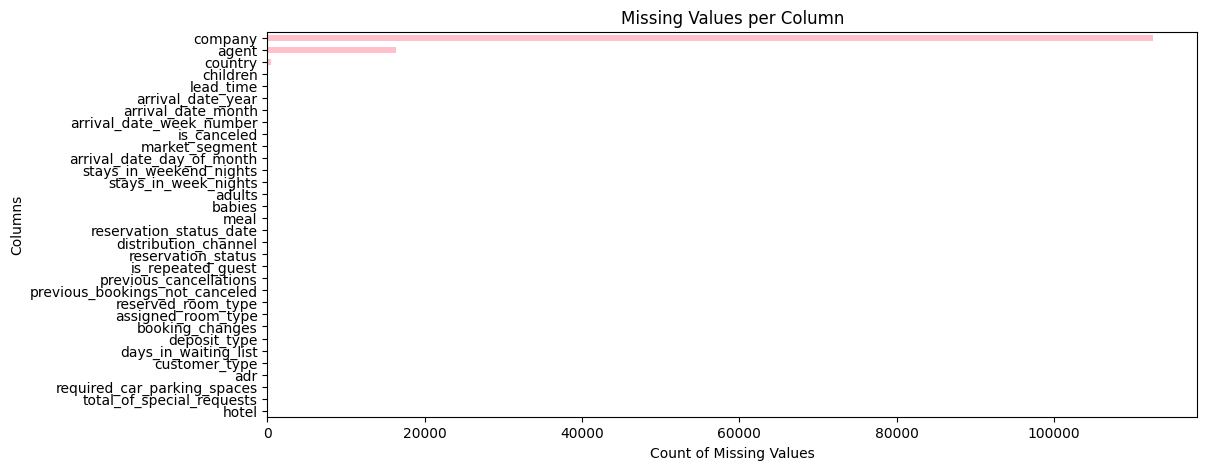

In [33]:
plt.figure(figsize=(12, 5))
missing_values.sort_values().plot(kind='barh', color='pink')
plt.title("Missing Values per Column")
plt.xlabel("Count of Missing Values")
plt.ylabel("Columns")
plt.show()

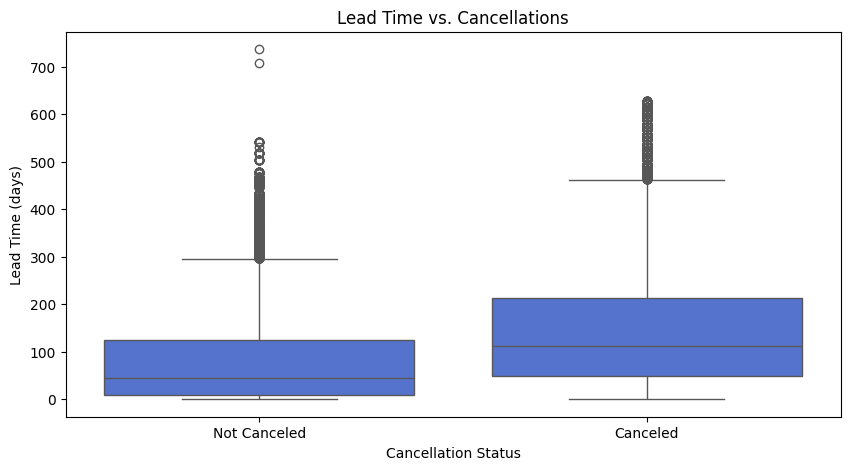

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='is_canceled', y='lead_time', color='royalblue')
plt.title("Lead Time vs. Cancellations")
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time (days)")
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.show()

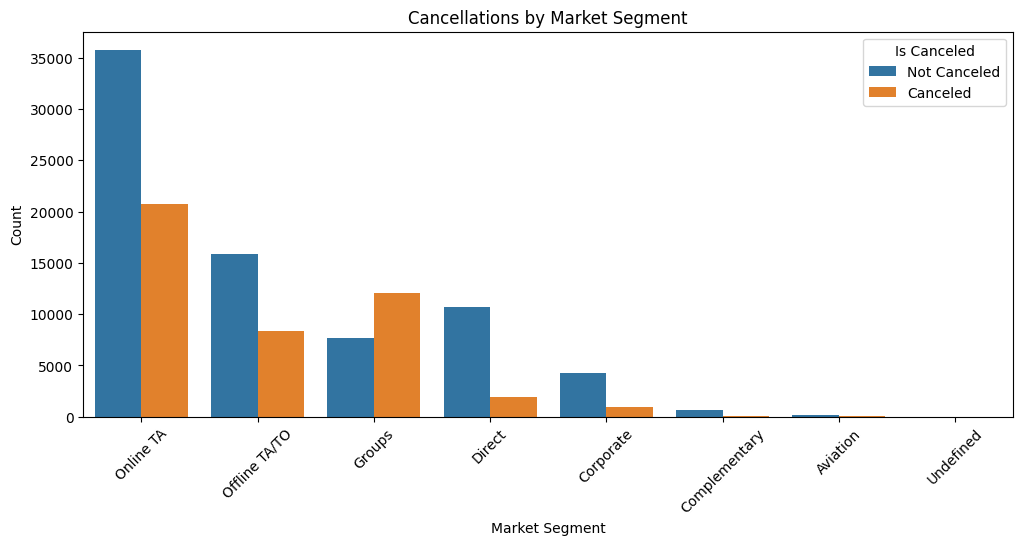

In [35]:
plt.figure(figsize=(12, 5))
sns.countplot(data=data, x='market_segment', hue='is_canceled', order=data['market_segment'].value_counts().index)
plt.title("Cancellations by Market Segment")
plt.xticks(rotation=45)
plt.xlabel("Market Segment")
plt.ylabel("Count")
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

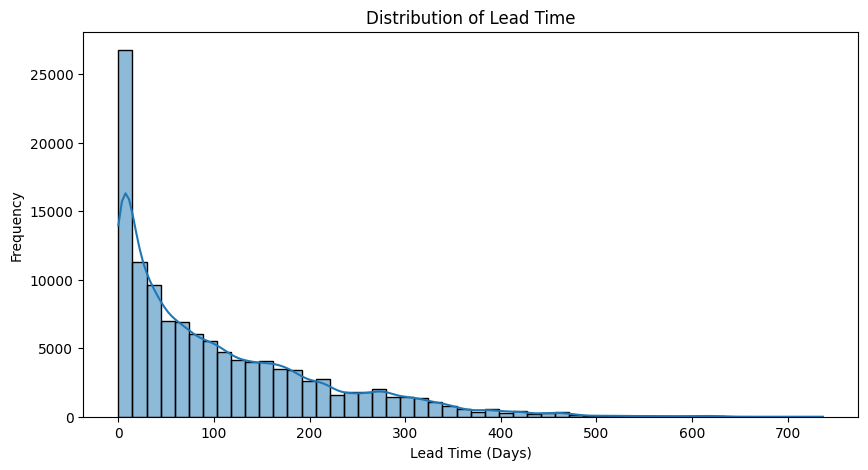

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(data['lead_time'], bins=50, kde=True, multiple='stack')
plt.title("Distribution of Lead Time")
plt.xlabel("Lead Time (Days)")
plt.ylabel("Frequency")
plt.show()

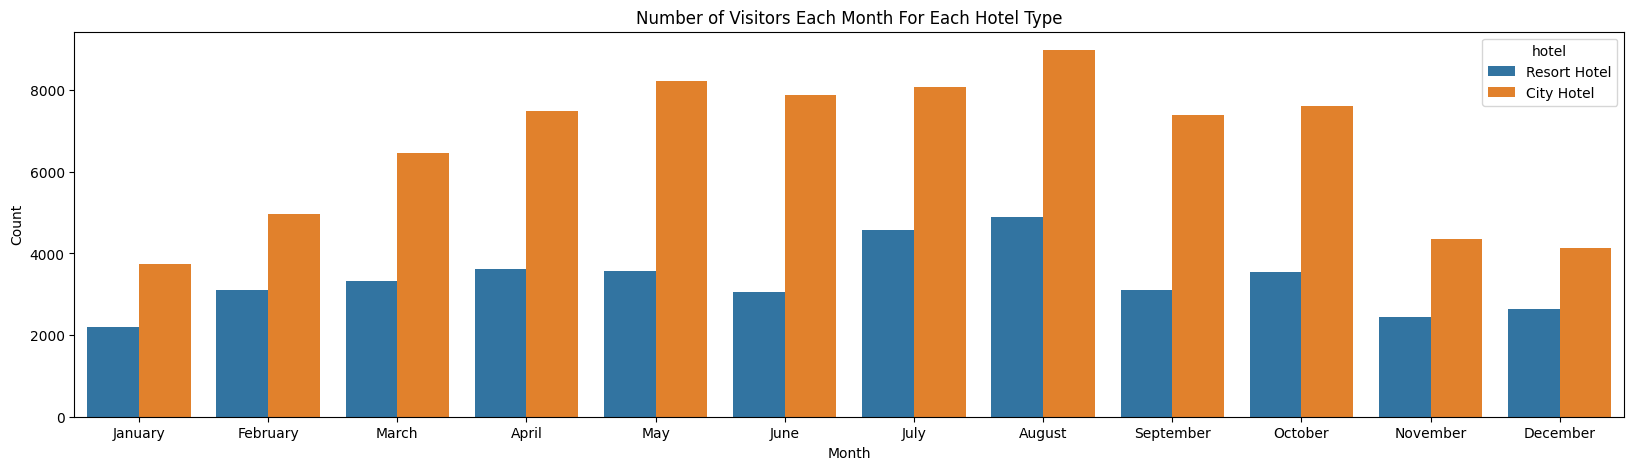

In [37]:
plt.figure(figsize=(20,5))
cols = ['hotel','arrival_date_month']
sns.countplot(data = data[cols],x= "arrival_date_month",hue="hotel",order=["January","February","March","April","May","June",
                                                                              "July","August","September","October","November","December"])
plt.title('Number of Visitors Each Month For Each Hotel Type')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

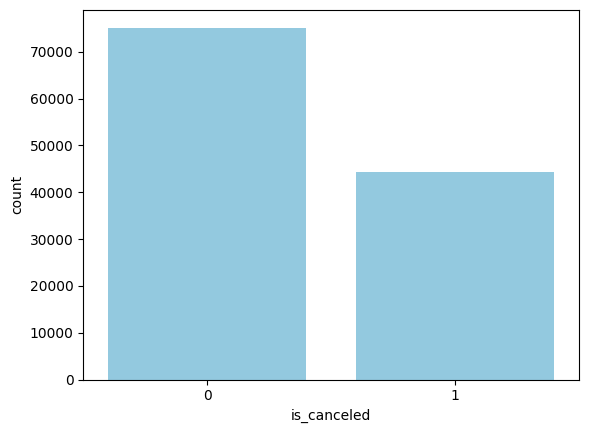

In [38]:
sns.countplot(x=data['is_canceled'], color='skyblue')
plt.show()

In [39]:
data.groupby('arrival_date_month')['is_canceled'].apply(lambda x: (x == 0).mean())

arrival_date_month
April        0.592028
August       0.622469
December     0.650295
February     0.665840
January      0.695227
July         0.625464
June         0.585428
March        0.678477
May          0.603342
November     0.687666
October      0.619534
September    0.608298
Name: is_canceled, dtype: float64

Below is a bar plot showing the aggregated cancelation rates from each month across hotels and years.

/var/folders/_d/_z2khbzn09dftql3lb1r49280000gn/T/ipykernel_79655/2293877017.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancel_rate = data.groupby('arrival_date_month')['is_canceled'].mean().reindex(month_order)


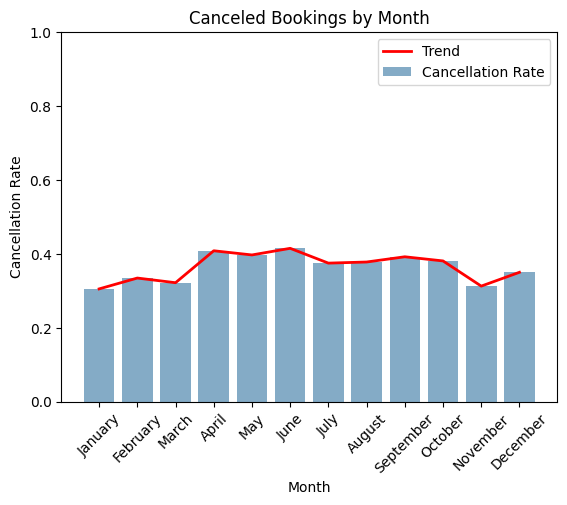

In [40]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
data['arrival_date_month'] = pd.Categorical(data['arrival_date_month'], categories=month_order, ordered=True)
cancel_rate = data.groupby('arrival_date_month')['is_canceled'].mean().reindex(month_order)
sns.barplot(x=cancel_rate.index, y=cancel_rate.values, alpha=0.6, label="Cancellation Rate")
sns.lineplot(x=cancel_rate.index, y=cancel_rate.values, color='red', linewidth=2, label="Trend")
plt.xlabel("Month")
plt.ylim(0, 1)
plt.ylabel("Cancellation Rate")
plt.title("Canceled Bookings by Month")
plt.xticks(rotation=45) 
plt.legend()
plt.show()

#### Multicollinearity check

We computed the variance inflation factors (VIFs) of our variables to check for multicollinearity. The results from this have not been included in our final report due to space constraints. 

In [41]:
copy = data.copy()
copy.drop(columns=['agent', 'company', 'country'], inplace=True) 
copy['children']=copy['children'].fillna(0)
copy['children'] = copy['children'].astype('int')
covariates = copy.select_dtypes(include=[np.number]).drop(columns=['is_canceled'])
vif_data = pd.DataFrame()
vif_data["Feature"] = covariates.columns
vif_data["VIF"] = [variance_inflation_factor(covariates.values, i) for i in range(len(covariates.columns))]
vif_data

,Feature,VIF
0,lead_time,2.226524
1,arrival_date_year,21.351778
2,arrival_date_week_number,5.137844
3,arrival_date_day_of_month,4.269930
4,stays_in_weekend_nights,2.506617
5,stays_in_week_nights,3.745507
6,adults,12.579161
7,children,1.203921
8,babies,1.024092
9,is_repeated_guest,1.304210


Based on VIF values over 5 above, it makes sense to remove adr, adults, arrival_date_year and arrival_date_week_number to avoid multicollinearity. We removed these features only for the first baseline model, Logistic Regression. 

In [42]:
copy.drop(columns=['arrival_date_year', 'arrival_date_week_number', 'adults', 'adr'], inplace=True)

#### Baseline Model 1: Logistic Regression

In [43]:
categorical_cols = copy.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.difference(['is_canceled', 'reservation_status', 'reservation_status_date'])
df_encoded = pd.get_dummies(copy, columns=categorical_cols, drop_first=True)
int_cols = copy.select_dtypes(include=['int64', 'int32'])
df_final = pd.concat([int_cols, df_encoded], axis=1)

X = df_final.drop(columns=['is_canceled', 'reservation_status', 'reservation_status_date'])
y = copy['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     15033
           1       0.82      0.56      0.66      8845

    accuracy                           0.79     23878
   macro avg       0.80      0.74      0.76     23878
weighted avg       0.80      0.79      0.78     23878



/Users/reema/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This yields an accuracy of 79%. 

#### Baseline Model 2: CatBoost

In [109]:
df = copy.copy()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.difference(['is_canceled', 'reservation_status', 'reservation_status_date'])
df[categorical_cols] = df[categorical_cols].astype(str)
X = df.drop(columns=['is_canceled', 'reservation_status', 'reservation_status_date'])
y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols if col in X_train.columns]
cat_model = CatBoostClassifier(
    iterations=500,       
    depth=6,              
    learning_rate=0.05,  
    loss_function='Logloss',  
    cat_features=cat_features_indices,  
    verbose=100, 
    random_seed=42
)

cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
clf_report = classification_report(y_test, y_pred_cat)
print(clf_report)


0:	learn: 0.6507792	total: 69.2ms	remaining: 34.5s
100:	learn: 0.3791610	total: 4.08s	remaining: 16.1s
200:	learn: 0.3668067	total: 8.28s	remaining: 12.3s
300:	learn: 0.3594902	total: 11.5s	remaining: 7.57s
400:	learn: 0.3539597	total: 14.6s	remaining: 3.6s
499:	learn: 0.3497473	total: 18.3s	remaining: 0us
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     15033
           1       0.85      0.67      0.75      8845

    accuracy                           0.83     23878
   macro avg       0.84      0.80      0.81     23878
weighted avg       0.84      0.83      0.83     23878



This yields an accuracy of 0.83. 

#### Advanced Model 1: RandomForestClassifier

In [45]:
df = data.copy()
useless_col = ['arrival_date_week_number', 'arrival_date_year','reservation_status', 'country'] 
df = df.drop(columns=useless_col)

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['month'] = df['reservation_status_date'].dt.month 

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['cancellation_ratio'] = np.where(df['lead_time'] > 0, df['previous_cancellations'] / df['lead_time'], 0)
df['special_requests_binary'] = (df['total_of_special_requests'] > 0).astype(int)
df.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations', 'total_of_special_requests'], inplace=True)
y = df['is_canceled']
df.drop(columns=['is_canceled'], inplace=True)
log_cols = ['adr'] 
for col in log_cols:
    df[col] = np.log1p(df[col])  

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
rd_clf = RandomForestClassifier(n_estimators=350, max_depth=15, random_state=42)
rd_clf.fit(X_train, y_train)
y_pred_rd_clf = rd_clf.predict(X_test)
clf_report = classification_report(y_test, y_pred_rd_clf)
print(clf_report)

/Users/reema/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


              precision    recall  f1-score   support

           0       0.86      0.97      0.92     14907
           1       0.95      0.75      0.83      8971

    accuracy                           0.89     23878
   macro avg       0.90      0.86      0.87     23878
weighted avg       0.89      0.89      0.89     23878



This yields an accuracy of 0.89.

#### Advanced Model 2: LightGBM

In [46]:
df = data.copy()
useless_col = ['arrival_date_week_number', 'arrival_date_year', 'reservation_status', 'country']
df = df.drop(columns=useless_col)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['month'] = df['reservation_status_date'].dt.month 
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['cancellation_ratio'] = np.where(df['lead_time'] > 0, df['previous_cancellations'] / df['lead_time'], 0)
df['special_requests_bool'] = (df['total_of_special_requests'] > 0).astype(int)
df.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations', 'total_of_special_requests'], inplace=True)
y = df['is_canceled']
df.drop(columns=['is_canceled'], inplace=True)
df['adr'] = np.log1p(df['adr']) 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
lgb_model = lgb.LGBMClassifier(
    n_estimators=350, 
    max_depth=15,  
    learning_rate=0.05, 
    num_leaves=64, 
    colsample_bytree=0.8,  
    subsample=0.8,  
    min_child_samples=20, 
    reg_lambda=0.3, 
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
clf_report = classification_report(y_test, y_pred_lgb)
print(f"Classification Report:\n{clf_report}")

/Users/reema/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[LightGBM] [Info] Number of positive: 35253, number of negative: 60259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1737
[LightGBM] [Info] Number of data points in the train set: 95512, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369095 -> initscore=-0.536101
[LightGBM] [Info] Start training from score -0.536101
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14907
           1       1.00      0.94      0.97      8971

    accuracy                           0.98     23878
   macro avg       0.98      0.97      0.97     23878
weighted avg       0.98      0.98      0.98     23878



This yields a way higher accuracy than before of 0.98. 

#### Feature Importance Analysis

Plotting the top 20 features that had the largest role in predicting the target variable in the LightGBM model.

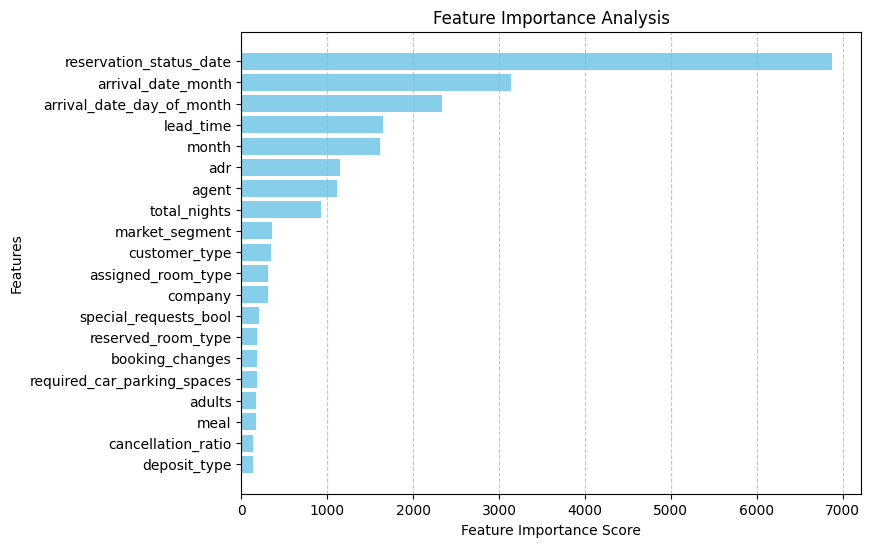

In [47]:
def plot_feature_importance(model, feature_names, top_n=20):
    feature_importances = model.feature_importances_
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
    feature_imp_df = feature_imp_df.head(top_n)
    plt.figure(figsize=(8, 6))
    plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance Analysis')
    plt.gca().invert_yaxis()  
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_feature_importance(lgb_model, X_train.columns, top_n=20)

#### Comparing Accuracies of Baseline models & Advanced models

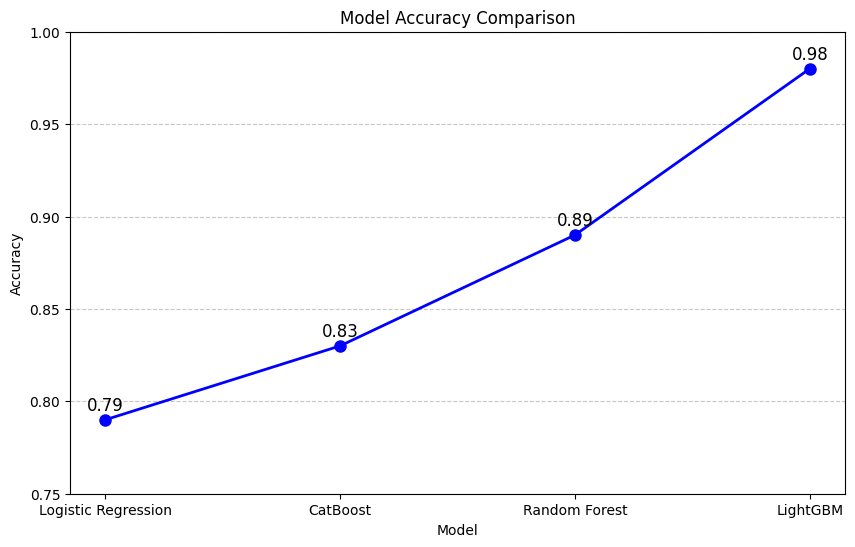

In [4]:
model = ['Logistic Regression', 'CatBoost', 'Random Forest', 'LightGBM']
accuracy = [0.79, 0.83, 0.89, 0.98]
plt.figure(figsize=(10, 6))
plt.plot(model, accuracy, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.75, 1.0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, acc in enumerate(accuracy):
    plt.text(model[i], acc + 0.005, f"{acc:.2f}", ha='center', fontsize=12)

plt.show()
